# ISI-effect on spike

purpose: demonstrate effect of ISI on extracellular spike amplitudes and related features such as spike width during bursting for a subsample of neurons 

Compare ISI on spike features for regular vs. bursting neurons.

**Method**:

- cSTUT, bSTUT, dSTUT are interneurons
- ISI threshold within burst ~ < 20 ms (Allen BD)
- at least 2 spikes (typically 2-4 spikes, Allen BD)
- keep units with at least 2 bursts for statistics

NOTE:
- Excitatory cells typically do not burst much at this age (Markram 2015)
- A quick analysis revealed no bursting with these parameters in the spontaneous simulation

### Setup

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

import os
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import spikeinterface as si
import spikeinterface
import spikeinterface.preprocessing as spre
from spikeinterface.postprocessing import compute_isi_histograms
from ipywidgets import interactive, widgets
import spikeinterface.widgets as sw
import spikeinterface as si
from scipy.spatial.distance import cdist
import seaborn as sns
import pandas as pd
from scipy.stats import wilcoxon
print(spikeinterface.__version__)

# move to PROJECT PATH
PROJ_PATH = "/home/steeve/steeve/epfl/code/spikebias"
os.chdir(PROJ_PATH)

matplotlib.rcParams['agg.path.chunksize'] = 10000

# preprocessing parameters
FREQ_MIN = 300
FREQ_MAX = 3000

# recording path
REC_PATH = "dataset/00_raw/recording_npx_evoked"  # full
GT_PATH = "dataset/00_raw/ground_truth_npx_evoked"  # full

# axes aesthetics
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6  # 5-7 with Nature neuroscience as reference
plt.rcParams["lines.linewidth"] = 0.5 # typically 0.5 - 1 pt
plt.rcParams["axes.linewidth"] = 0.5 # typically 0.5 - 1 pt
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.major.size"] = 3.5 * 1.1
plt.rcParams["xtick.minor.size"] = 2 * 1.1
plt.rcParams["ytick.major.size"] = 3.5 * 1.1
plt.rcParams["ytick.minor.size"] = 2 * 1.1
savefig_cfg = {"transparent":True, "dpi":300, 'bbox_inches':'tight'}
legend_cfg = {"frameon": False, "handletextpad": 0.1}
tight_layout_cfg = {"pad": 0.5}
LG_FRAMEON = False              # no legend frame

0.100.5


### Functions

In [18]:
def shorten_waveform(waveforms: np.array, window_to_search_peak_sec=2.5, sampling_freq=20000):

    # calculate shorter window
    sample_sec = (1/sampling_freq) * 1000
    shorter_window = int(window_to_search_peak_sec / sample_sec)

    # get shorter window
    mid_point = int(waveforms.shape[1] / 2 )
    wind_start = int(mid_point - shorter_window/2)
    wind_end =  int(mid_point + shorter_window/2)
    shorter_window_sample = np.arange(wind_start, wind_end, 1).astype(int)
    return waveforms[:, shorter_window_sample], wind_start, wind_end


def align_by_neg_peak_and_crop(waves, sampling_frequency, window_to_search_peak_sec=2.5, window=100, peak_pos=50):
    """
    W: array of shape (n_waveforms, n_samples) e.g. (N, 480)
    window: number of samples in the output window (e.g. 100)
    peak_pos: index in [0, window-1] where the negative peak will be placed (e.g. 50)
    fill_value: value used when the 100-sample window would run beyond the edges
    Returns: array of shape (n_waveforms, window)
    """
    
    # find peak index in shortened waveform
    # shorten waveform to find peak without spike collision
    short_waves, wind_start, wind_end = shorten_waveform(waves, window_to_search_peak_sec=window_to_search_peak_sec, sampling_freq=sampling_frequency)

    num_waves, _ = short_waves.shape
    left = peak_pos
    right = window - left  # number of samples to include to the right of the peak
    aligned = np.full((num_waves, window), np.nan, dtype=short_waves.dtype) # placeholder of nans

    # index of negative peak for each waveform
    trough_idx = np.argmin(short_waves, axis=1)

    # locate peak index in longer waveforms
    trough_idx = trough_idx + wind_start

    # number of timepoints in longer waves
    n_timepoints = waves.shape[1]

    for w_ix in range(num_waves):

        # desired window in original signal: [p-left, p+right)
        src_start = max(0, trough_idx[w_ix] - left)
        src_end   = min(n_timepoints, trough_idx[w_ix] + right)
        
        # where to place it in the output (shift if we clipped at edges)
        dst_start = max(0, left - trough_idx[w_ix])          # how many samples we clipped on the left
        dst_end   = dst_start + (src_end - src_start)

        # align
        aligned[w_ix, dst_start:dst_end] = waves[w_ix, src_start:src_end]
    return aligned


def distinct_greys(N):
    # values from black (0) to white (1)
    vals = np.linspace(0, 1, N)
    # return as RGB triples
    return np.stack([vals, vals, vals], axis=1)


def distinct_cmap(cmap_name, N):
    cmap = plt.cm.get_cmap(cmap_name, N)  # sample N discrete colors
    return [cmap(i) for i in range(N)]


def find_bursts_isi(spike_times, isi_threshold=0.01, min_spikes=3, min_duration=0.02):
    """
    Find bursts based on inter-spike interval (ISI) criterion.
    
    Parameters:
    spike_times: array-like, spike timestamps in seconds
    isi_threshold: float, maximum ISI within burst (seconds)
    min_spikes: int, minimum number of spikes to constitute a burst
    min_duration: float, minimum burst duration (seconds)
    
    Returns:
    list of tuples: [(burst_start, burst_end, n_spikes, burst_duration), ...]
    """
    if len(spike_times) < min_spikes:
        return []
    
    spike_times = np.array(spike_times)
    spike_times = np.sort(spike_times)  # ensure sorted
    
    # Calculate inter-spike intervals
    isis = np.diff(spike_times)
    
    # Find potential burst boundaries
    # Spikes are in same burst if ISI < threshold
    in_burst = (0 <= isis) & (isis <= isi_threshold)
    
    # find burst start and end indices
    burst_starts = []
    burst_ends = []
    
    i = 0
    while i < len(in_burst):
        if in_burst[i]:  # Start of potential burst
            burst_start_idx = i
            
            # Find end of burst
            while i < len(in_burst) and in_burst[i]:
                i += 1
            burst_end_idx = i  # One past the last spike in burst
            
            # Check if this burst meets criteria
            n_spikes_in_burst = burst_end_idx - burst_start_idx + 1
            burst_duration = spike_times[burst_end_idx] - spike_times[burst_start_idx]
            
            if n_spikes_in_burst >= min_spikes and burst_duration >= min_duration:
                burst_starts.append(burst_start_idx)
                burst_ends.append(burst_end_idx)
        else:
            i += 1
    
    # extract burst information
    bursts = []
    for start_idx, end_idx in zip(burst_starts, burst_ends):
        burst_start_time = spike_times[start_idx]
        burst_end_time = spike_times[end_idx]
        n_spikes = end_idx - start_idx + 1
        duration = burst_end_time - burst_start_time
        
        bursts.append((burst_start_time, burst_end_time, n_spikes, duration))
    
    return bursts


def find_in_isi_range(spike_times, min_isi=0.01, max_isi=0.02, min_spikes=3, min_duration=0.02):
    """
    Find bursts based on inter-spike interval (ISI) criterion.
    
    Parameters:
    spike_times: array-like, spike timestamps in seconds
    isi_threshold: float, maximum ISI within burst (seconds)
    min_spikes: int, minimum number of spikes to constitute a burst
    min_duration: float, minimum burst duration (seconds)
    
    Returns:
    list of tuples: [(burst_start, burst_end, n_spikes, burst_duration), ...]
    """
    if len(spike_times) < min_spikes:
        return []
    
    spike_times = np.array(spike_times)
    spike_times = np.sort(spike_times)  # ensure sorted
    
    # Calculate inter-spike intervals
    isis = np.diff(spike_times)
    
    # Find potential burst boundaries
    # Spikes are in same burst if ISI < threshold
    in_isi_range = (min_isi <= isis) & (isis <= max_isi)
    
    # find burst start and end indices
    isi_sequence_starts = []
    isi_sequence_ends = []
    
    i = 0
    while i < len(in_isi_range):
        if in_isi_range[i]:
            isi_sequence_start_idx = i
            
            # Find end of burst
            while i < len(in_isi_range) and in_isi_range[i]:
                i += 1
            isi_sequence_end_idx = i  # One past the last spike in burst
            
            # Check if this burst meets criteria
            n_spikes_in_isi_range = isi_sequence_end_idx - isi_sequence_start_idx + 1
            sequence_duration = spike_times[isi_sequence_end_idx] - spike_times[isi_sequence_start_idx]
            
            if n_spikes_in_isi_range >= min_spikes and sequence_duration >= min_duration:
                isi_sequence_starts.append(isi_sequence_start_idx)
                isi_sequence_ends.append(isi_sequence_end_idx)
        else:
            i += 1
    
    # extract burst information
    isi_sequences = []
    for start_idx, end_idx in zip(isi_sequence_starts, isi_sequence_ends):
        isi_sequence_start_time = spike_times[start_idx]
        isi_sequence_end_time = spike_times[end_idx]
        n_spikes = end_idx - start_idx + 1
        duration = isi_sequence_end_time - isi_sequence_start_time
        
        isi_sequences.append((isi_sequence_start_time, isi_sequence_end_time, n_spikes, duration))
    return isi_sequences


def test_find_bursts_isi():
    
    # setup burst parameters
    isi_threshold_sec = 0.015 
    min_spikes = 4
    
    # create test spike timestamps with two bursts of 5 and 7 spikes
    test_spikes_sec = np.sort(np.hstack([np.arange(0,100,1), 10.01, 10.02, 10.03, 10.04, 80, 80.01, 80.02, 80.03, 80.04, 80.05]))
    assert find_bursts_isi(test_spikes_sec, isi_threshold=isi_threshold_sec, min_spikes=min_spikes)==[(10.0, 10.04, 5, 0.03999999999999915), (80.0, 80.05, 7, 0.04999999999999716)], "wrong"


def plot_burst_spikes(Recording, Gtruth, sfreq, burst, b_unit, peak_pos, window, ms_before, ms_after, plot_trace=True, verbose=False, title=''):
    
    burst_start = burst[0]
    burst_end = burst[1]

    start_frame = int(burst_start * sfreq)
    end_frame = int(burst_end * sfreq)

    unit_spike_frames = Gtruth.get_unit_spike_train(b_unit)
    burst_frames_loc = (start_frame <= unit_spike_frames) & (end_frame >= unit_spike_frames)
    burst_frames = unit_spike_frames[burst_frames_loc]
    n_b_spikes = len(burst_frames)

    # plot burst spikes
    # - find nearest electrode
    site_ids = Recording.get_channel_ids()
    sites_coord = Recording.get_channel_locations(axes='xyz')
    b_unit_loc = np.where(Gtruth.unit_ids == b_unit)[0][0]
    units_coord = np.array([Gtruth.get_property('x'), Gtruth.get_property('y'), Gtruth.get_property('z')]).T
    b_unit_coord = units_coord[b_unit_loc,:]
    dist_matrix = cdist(b_unit_coord[None], sites_coord) 
    closest_site = np.argmin(dist_matrix)
    if verbose:
        print('closest site id:', site_ids[closest_site])

    # plot voltage trace during burst
    plt.figure(figsize=(20,2))
    frames_before = 100
    frames_after = 100
    bursting_trace = Recording.get_traces(start_frame=start_frame-frames_before, end_frame=end_frame + frames_after, channel_ids=[site_ids[closest_site]])
    if plot_trace:
        plt.plot(bursting_trace)
        plt.plot(frames_before + burst_frames - burst_frames[0], np.zeros(len(burst_frames)),'o')

    # plot spike waveforms within burst
    plt.figure(figsize=(3,2))

    #colors = distinct_greys(n_b_spikes + 2)
    colors = distinct_cmap("hot", n_b_spikes + 2)

    # - loop over spikes timestamp
    waves = []
    for s_i, b_frame in enumerate(burst_frames):
        wave = Recording.get_traces(start_frame=burst_frames[s_i]-frames_before, end_frame=burst_frames[s_i] + frames_after, channel_ids=[site_ids[closest_site]])
        waves.append(wave)
    waves = np.array(waves).squeeze()

    aligned_waves = align_by_neg_peak_and_crop(np.array(waves), sfreq, window_to_search_peak_sec=2.5, window=window, peak_pos=peak_pos)

    for w_i, wave in enumerate(aligned_waves):
        plt.plot(wave, color=colors[w_i], label=f'spike {w_i}', linewidth=1)

    plt.xticks([0, peak_pos, window], [-ms_before, 0, ms_after])
    plt.legend(bbox_to_anchor=(1.05, 1));
    plt.xlabel('Time (ms)')
    plt.title(title)


def get_burst_first_n_waveforms(Recording, Gtruth, bursts, b_unit, sfreq, peak_pos=50, window=100, frames_before=100, frames_after=100, num_spikes=2):
    
    # find the unit's nearest electrode
    site_ids = Recording.get_channel_ids()
    sites_coord = Recording.get_channel_locations(axes='xyz')
    b_unit_loc = np.where(Gtruth.unit_ids == b_unit)[0][0]
    units_coord = np.array([Gtruth.get_property('x'), Gtruth.get_property('y'), Gtruth.get_property('z')]).T
    b_unit_coord = units_coord[b_unit_loc,:]
    dist_matrix = cdist(b_unit_coord[None], sites_coord) 
    closest_site = np.argmin(dist_matrix)

    # get the spike frames (timestamps) of the unit
    unit_spike_frames = Gtruth.get_unit_spike_train(b_unit)

    # store the first two waves of each burst
    waves_by_burst = []
    
    # loop over each burst and collect its first and second
    # spike waveform all aligned on their negative peak
    # at peak_pos (default 50th frame)
    for b_ix in range(len(bursts[b_unit])):
        try:
            burst = bursts[b_unit][b_ix]
            burst_start = burst[0]
            burst_end = burst[1]
            start_frame = int(burst_start * sfreq)
            end_frame = int(burst_end * sfreq)

            burst_frames_loc = (start_frame <= unit_spike_frames) & (end_frame >= unit_spike_frames)
            burst_frames = unit_spike_frames[burst_frames_loc]

            # store the waves in this burst
            waves = []
            for s_i, _ in enumerate(burst_frames):
                wave = Recording.get_traces(start_frame=burst_frames[s_i]-frames_before, end_frame=burst_frames[s_i] + frames_after, channel_ids=[site_ids[closest_site]])
                waves.append(wave)
            waves = np.array(waves).squeeze()

            # align waves at frame 50, crop to 100 frames (waves, frames)
            aligned_waves = align_by_neg_peak_and_crop(np.array(waves), sfreq, window_to_search_peak_sec=2.5, window=window, peak_pos=peak_pos)
            
            # store the first two waves of each burst
            if aligned_waves.shape[0] >= num_spikes:
                waves_by_burst.append(aligned_waves[:num_spikes,:])
        except:
            pass

    # (burst, waves, frames)
    return np.array(waves_by_burst)


def get_first_n_waveforms(Recording, Gtruth, b_unit, sfreq, peak_pos=50, window=100, frames_before=100, frames_after=100, num_spikes=2):
    
    # find the unit's nearest electrode
    site_ids = Recording.get_channel_ids()
    sites_coord = Recording.get_channel_locations(axes='xyz')
    b_unit_loc = np.where(Gtruth.unit_ids == b_unit)[0][0]
    units_coord = np.array([Gtruth.get_property('x'), Gtruth.get_property('y'), Gtruth.get_property('z')]).T
    b_unit_coord = units_coord[b_unit_loc,:]
    dist_matrix = cdist(b_unit_coord[None], sites_coord) 
    closest_site = np.argmin(dist_matrix)

    # get the spike frames (timestamps) of the unit
    unit_spike_frames = Gtruth.get_unit_spike_train(b_unit)

    # loop over each spike ttp and collect its first and second
    # spike waveform all aligned on their negative peak
    # at peak_pos (default 50th frame)
    waves = []
    for s_i in range(num_spikes):
        wave = Recording.get_traces(start_frame=unit_spike_frames[s_i]-frames_before, end_frame=unit_spike_frames[s_i] + frames_after, channel_ids=[site_ids[closest_site]])
        waves.append(wave)
    waves = np.array(waves)

    # align waves at frame 50, crop to 100 frames (waves, frames)
    aligned_waves = align_by_neg_peak_and_crop(np.array(waves), sfreq, window_to_search_peak_sec=2.5, window=window, peak_pos=peak_pos)
    return aligned_waves


def plot_mean_with_ci_line(ax, x, mean_vector, ci_lower, ci_upper, 
                          title="Mean with 95% Confidence Interval", 
                          linecolor='k', areacolor='grey',
                          linelabel='',
                          arealabel='',
                          xlabel="X", ylabel="Y"):
    """
    Plot mean vector with confidence interval as shaded area (line plot).
    
    Parameters:
    x: array-like, x-axis values
    mean_vector: array-like, mean values
    ci_lower: array-like, lower bound of 95% CI
    ci_upper: array-like, upper bound of 95% CI
    title: str, plot title
    xlabel: str, x-axis label
    ylabel: str, y-axis label
    
    Returns:
    fig, ax: matplotlib figure and axis objects
    """    
    
    # plot mean line
    ax.plot(x, mean_vector, 'b-', linewidth=2, label=linelabel, color=linecolor)
    
    # fill confidence interval area
    ax.fill_between(x, ci_lower, ci_upper, alpha=0.3, color=areacolor, 
                    label=arealabel)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)    
    return fig, ax


def ci95(data: np.array) -> np.array:
    """
    Args:
        data: 3d array. ci calculated along axis 0.
    
    Returns:
        a 2d array
    """
    return 1.96 *  np.nanstd(data, axis=0) / np.sqrt(np.sum(~np.isnan(data), axis=0))


def trough_width_halfmax(waveform, fs):
    """
    Calculate trough width at half maximum (FWHM) for a spike waveform.
    
    Parameters
    ----------
    waveform : 1D np.array
        Spike waveform (extracellular, negative trough).
    fs : float
        Sampling frequency in Hz.
        
    Returns
    -------
    width_ms : float
        Width at half maximum in milliseconds.
    """
    # Baseline correction (subtract pre-spike mean)
    wf = waveform
    
    # Find trough (minimum)
    trough_idx = np.argmin(wf)
    trough_val = wf[trough_idx]
    
    #  Half amplitude value
    half_val = trough_val / 2.0  # still negative
    
    # Find left crossing (before trough)
    left_idx_candidates = np.where(wf[:trough_idx] > half_val)[0]
    left_idx = left_idx_candidates[-1] if len(left_idx_candidates) > 0 else 0
    
    # Find right crossing (after trough)
    right_idx_candidates = np.where(wf[trough_idx:] > half_val)[0]
    right_idx = (
        right_idx_candidates[0] + trough_idx 
        if len(right_idx_candidates) > 0 
        else len(wf)-1
    )
    
    # Compute width in ms
    width_samples = right_idx - left_idx
    width_ms = (width_samples / fs) * 1000.0
    return width_ms


def plot_amplitude_modulation_by_isi(ax, Recording, Gtruth, unit_ids, sfreq, min_isi, max_isi, 
                                     min_spikes, window_frames, num_spikes, min_duration=0.02, min_amplitude=0):

    # loop over non-bursting units
    sequences_in_isi_range = dict()
    n_sequences = []
    for unit in unit_ids:
        spike_ttp_secs = Gtruth.get_unit_spike_train(unit) / sfreq # timestamps in seconds
        sequence_in_isi_range = find_in_isi_range(spike_ttp_secs, min_isi=min_isi, max_isi=max_isi, min_spikes=min_spikes, min_duration=min_duration)
        n_sequences.append(len(sequence_in_isi_range))
        sequences_in_isi_range[unit] = sequence_in_isi_range

    # Plot mean and ci95 of first two spikes with ISI within range -----------------------
    mean_waves_all = []

    for unit_ix in range(len(unit_ids)):
        
        b_unit = unit_ids[unit_ix] # unit id

        if len(sequences_in_isi_range[b_unit]) > 1: # unit with > 1 sequence for stats

            # first 2 waveforms in all sequences for this unit
            waves_by_burst = get_burst_first_n_waveforms(Recording, Gtruth, sequences_in_isi_range, b_unit, sfreq, peak_pos=int(window_frames/2), window=window_frames, frames_before=100, frames_after=100, num_spikes=num_spikes)
            mean_waves = waves_by_burst.mean(axis=0) # mean of first and second burst spikes over bursts
            mean_waves_all.append(mean_waves) # store

    # select high snr waveforms
    mean_waves_all = [x for x in mean_waves_all if x is not None and not np.isnan(x).all()]
    mean_waves_all = [x for x in mean_waves_all if x.min() <= min_amplitude]
    neg_amps = np.array(mean_waves_all).min(axis=(2))

    # Compute data for stats --------------------------------------------------

    df = pd.DataFrame()
    neg_amp_1st_spikes = neg_amps[:,0] # by unit
    neg_amp_2nd_spikes = neg_amps[:,1] # by unit
    df['Amplitudes'] = pd.DataFrame(np.hstack([neg_amp_1st_spikes, neg_amp_2nd_spikes]))
    df['Spike rank'] = ['1st'] * len(neg_amp_1st_spikes) + ['2nd'] * len(neg_amp_2nd_spikes)

    # setup plot
    ax = sns.boxplot(
        ax=ax,
        data=df,
        x="Spike rank",
        y="Amplitudes",
        notch=True,
        palette=["k", "r"],
        width=0.4,
        linewidth=0.5,
        flierprops={
            "marker": ".",
            "markersize": 3,
        },
    );

    # minor ticks
    locmin = matplotlib.ticker.LogLocator(
        base=10.0,
        subs=np.arange(0, 1.1, 0.1),
        numticks=10,
    );

    # axes
    ax.spines[["top", "right"]].set_visible(False);
    ax.legend("", frameon=False);

    # disconnect axes (R style)
    ax.spines["bottom"].set_position(("axes", -0.05));
    ax.yaxis.set_ticks_position("left");
    ax.spines["left"].set_position(("axes", -0.05));

    # mark 0 uV
    ax.hlines(xmin=-0.2, xmax=1.2, y=0, color='k', linewidth=1, linestyle='--');
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    # statistical test (Wicoxon signed-rank test, a non-parametric paired t-test)
    z, p = wilcoxon(neg_amp_1st_spikes, y=neg_amp_2nd_spikes, zero_method='wilcox', correction=False, alternative='less')
    print(f"""Wilcoxon test: 1 vs. 2, z={z}, p={p}, N_1={len(neg_amp_1st_spikes)}""")
    return z, p, df


def plot_width_modulation_by_isi(ax, Recording, Gtruth, unit_ids, sfreq, min_isi, max_isi, min_spikes, window_frames, num_spikes, min_duration=0.02, min_amplitude=0):

    # loop over non-bursting units
    sequences_in_isi_range = dict()
    n_sequences = []
    for unit in unit_ids:
        spike_ttp_secs = Gtruth.get_unit_spike_train(unit) / sfreq # timestamps in seconds
        sequence_in_isi_range = find_in_isi_range(spike_ttp_secs, min_isi=min_isi, max_isi=max_isi, min_spikes=min_spikes, min_duration=min_duration)
        n_sequences.append(len(sequence_in_isi_range))
        sequences_in_isi_range[unit] = sequence_in_isi_range

    # Plot mean and ci95 of first two spikes with ISI within range -----------------------
    mean_waves_all = []
    width = []
    widths = None

    for unit_ix in range(len(unit_ids)):
        
        b_unit = unit_ids[unit_ix] # unit id

        if len(sequences_in_isi_range[b_unit]) > 1: # unit with > 1 sequence for stats

            # first 2 waveforms in all sequences for this unit
            waves_by_burst = get_burst_first_n_waveforms(Recording, Gtruth, sequences_in_isi_range, b_unit, sfreq, peak_pos=int(window_frames/2), window=window_frames, frames_before=100, frames_after=100, num_spikes=num_spikes)            
            mean_waves = waves_by_burst.mean(axis=0) # mean of first and second burst spikes over bursts
            mean_waves_all.append(mean_waves) # store
            
    # select high snr waveforms
    mean_waves_all = [x for x in mean_waves_all if x is not None and not np.isnan(x).all()]
    mean_waves_all = [x for x in mean_waves_all if x.min() <= min_amplitude]

    # compute widths for clean waveforms
    # for each kept unit
    # mean_waves_all (n kept units, num spikes, n_frames)
    width = []
    for ix in range(len(mean_waves_all)):
        width_spike_1 = trough_width_halfmax(mean_waves_all[ix][0], sfreq) # width spike 1
        width_spike_2 = trough_width_halfmax(mean_waves_all[ix][1], sfreq) # width spike 2
        width.append([width_spike_1, width_spike_2])
    widths = np.array(width)

    # Compute data for stats --------------------------------------------------

    df = pd.DataFrame()
    width_1st_spikes = widths[:,0] # by unit
    width_2nd_spikes = widths[:,1] # by unit
    df['Spike widths (ms)'] = pd.DataFrame(np.hstack([width_1st_spikes, width_2nd_spikes]))
    df['Spike rank'] = ['1st'] * len(width_1st_spikes) + ['2nd'] * len(width_2nd_spikes)

    # setup plot
    ax = sns.boxplot(
        ax=ax,
        data=df,
        x="Spike rank",
        y="Spike widths (ms)",
        notch=True,
        palette=["k", "r"],
        width=0.4,
        linewidth=0.5,
        flierprops={
            "marker": ".",
            "markersize": 3,
        },
    );

    # minor ticks
    locmin = matplotlib.ticker.LogLocator(
        base=10.0,
        subs=np.arange(0, 1.1, 0.1),
        numticks=10,
    );

    # axes
    ax.spines[["top", "right"]].set_visible(False);
    ax.legend("", frameon=False);

    # disconnect axes (R style)
    ax.spines["bottom"].set_position(("axes", -0.05));
    ax.yaxis.set_ticks_position("left");
    ax.spines["left"].set_position(("axes", -0.05));

    # mark 0 uV
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    # statistical test (Wicoxon signed-rank test, a non-parametric paired t-test)
    z, p = wilcoxon(width_1st_spikes, y=width_2nd_spikes, zero_method='wilcox', correction=False, alternative='greater')
    print(f"""Wilcoxon test: 1 vs. 2, z={z}, p={p}, N_1={len(width_1st_spikes)}""")
    return z,p,df

## Load dataset

In [3]:
%%time

# load
Recording = si.load_extractor(REC_PATH)

# preprocess
Recording = spre.astype(Recording, "int16")
Recording = spre.bandpass_filter(Recording, freq_min=FREQ_MIN, freq_max=FREQ_MAX)
Recording = spre.common_reference(Recording, reference="global", operator="median")
Recording = spre.whiten(Recording, dtype='float32') # requires float

# get metadata
sfreq = Recording.get_sampling_frequency()
nframes = Recording.get_num_frames()

display(Recording)

WhitenRecording: 384 channels - 20.0kHz - 1 segments - 72,359,964 samples - 3,618.00s (1.00 hours) 
                 float32 dtype - 103.51 GiB

CPU times: user 3.98 s, sys: 2.56 s, total: 6.54 s
Wall time: 1.86 s


In [4]:
# Load ground truth and select bursting mtypes 
Gtruth = si.load_extractor(GT_PATH)
mtypes = Gtruth.get_property("mtype")
etypes = Gtruth.get_property("etype")
synapse = Gtruth.get_property("synapse_class")
layer = Gtruth.get_property("layer")
unit_ids = Gtruth.unit_ids

### Compute ISI hist

In [5]:
%%time 

# select units 
#loc = (synapse=="INH") & ((layer == "2") | (layer == "3") | (layer == "5"))
loc = (synapse=="INH") | (synapse=="EXC") 
#loc = (synapse=="INH")

# check whether cell is there
if not any(loc):
    raise ValueError("No cell found")
else:
    print('number of cells found:', sum(loc))
    print('their etype:', etypes[loc])
    print('their mtype:', mtypes[loc])
    print('their synapse:', synapse[loc])

unit_ids = np.unique(Gtruth.unit_ids[loc])
Gtruth = Gtruth.select_units(unit_ids)

# Compute ISI
isi_histogram, bins =  compute_isi_histograms(Gtruth,
                                              window_ms=1000, # 10000: between 0 and 10 seconds ISI
                                              bin_ms=1.0,
                                              method="auto")

number of cells found: 1836
their etype: ['cADpyr' 'cADpyr' 'cADpyr' ... 'cACint' 'cACint' 'cACint']
their mtype: ['L3_TPC:A' 'L3_TPC:A' 'L3_TPC:A' ... 'L5_MC' 'L5_MC' 'L5_MC']
their synapse: ['EXC' 'EXC' 'EXC' ... 'INH' 'INH' 'INH']
CPU times: user 4.12 s, sys: 791 ms, total: 4.91 s
Wall time: 3.87 s


### plot ISI hist

1389217, 3477831; 3583934

2204240

In [18]:
# # plot interactively (one unit at a time)
# def update_plot(cell_ix):
#     plt.plot(isi_histogram[cell_ix,:])
#     plt.xlabel('ISI (ms)')
#     print('unit id:', Gtruth.unit_ids[cell_ix])
#     print("n spikes:", len(Gtruth.get_unit_spike_train(unit_id=Gtruth.unit_ids[cell_ix])))
#     print("n spikes within window:", isi_histogram[cell_ix,:].sum())

# # get slider's value interactively
# slider = widgets.IntSlider(
#     value=0,
#     min=0,
#     max=len(Gtruth.unit_ids) - 1,
#     step=1,
#     disabled=False,
#     continuous_update=False,
#     orientation="horizontal",
#     readout=True,
#     readout_format="d",
# )

# # plot interactively
# interactive(update_plot, cell_ix=slider)

### plot Raster

In [19]:
# # plot units, time chunks by time chunks
# plt.figure(figsize=(20,10))

# # fixed window length (seconds)
# window_length = 1 # as  in fig11, Markram 2015

# # total duration in seconds (from the recording associated with Gtruth)
# total_duration_s = nframes / sfreq

# # slider for start time
# start_slider = widgets.FloatSlider(
#     value=0,
#     min=0,
#     max=total_duration_s - window_length,
#     step=window_length/3,
#     description='Start (s):',
#     continuous_update=False,
#     layout={'width': '800px'}
# )

# def update_plot_all_units(start):
#     """interactive raster plot

#     Args:
#         start (_type_): _description_
#     """
#     time_range = (start, start + window_length)
#     sw.plot_rasters(Gtruth, unit_ids=unit_ids, time_range=time_range, figsize=(3,6));

# out = widgets.interactive_output(update_plot_all_units, {'start': start_slider})
# display(start_slider, out)

In [20]:
# # plot units, unit chunks by unit chunks

# # fixed window length (seconds)
# unit_range = 50             # as in fig11, Markram 2015

# # slider for start time
# start_slider = widgets.FloatSlider(
#     value=0,
#     min=0,
#     max=len(unit_ids) - unit_range,
#     step=unit_range,
#     description='Start (s):',
#     continuous_update=False,
#     layout={'width': '800px'}
# )

# def update_plot(unit_start):
#     """interactive raster plot

#     Args:
#         start (_type_): _description_
#     """
#     time_range = (0, 1)
#     unit_ix = np.arange(unit_start, unit_start + unit_range, 1).astype(int)
#     sw.plot_rasters(Gtruth, unit_ids=unit_ids[unit_ix], time_range=time_range, figsize=(3,6));

# out = widgets.interactive_output(update_plot, {'unit_start': start_slider})
# display(start_slider, out)

## Bursting units

Burst definition:   
    - > 3 spikes (at least 4 spikes)  
    - Burst ISI thresh: 20 ms

Unit '506676':  
    - 59 bursts with at   
    - qualitatively acceptable SNR burst indices: 2, 4, 5, 6, 11, 23

Unit '2281009':  
    - 2 bursts  
    - qualitatively acceptable SNR burst index: 1  


### Burst >= 3 spikes

number of bursting units: 4
bursting units: ['2281009' '2873667' '3972082' '506676']
CPU times: user 225 ms, sys: 120 µs, total: 225 ms
Wall time: 225 ms


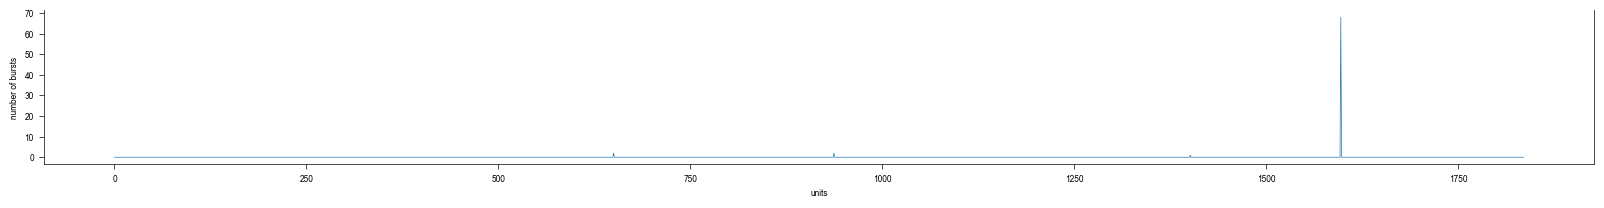

In [20]:
%%time 

# find bursting units

# setup burst parameters
min_spikes = 3           # minimum spike in burst ((min=2 max 4 as in Allen BD)
isi_thresh_sec = 0.021   # (default=20 ms as in Allen BD, 2020, JN)

# find bursts
bursts = dict()
n_bursts = []
for unit in unit_ids:
    spike_ttp_secs = Gtruth.get_unit_spike_train(unit) / sfreq # timestamps in seconds
    burst = find_bursts_isi(spike_ttp_secs, isi_threshold=isi_thresh_sec, min_spikes=min_spikes)
    n_bursts.append(len(burst))
    bursts[unit] = burst

# unit-test
test_find_bursts_isi()

# plot number of bursts by cell
plt.figure(figsize=(20,2))
plt.plot(n_bursts)
plt.ylabel('number of bursts')
plt.xlabel('units')

# find bursting unit ids
bursting_units = unit_ids[np.where(np.array(n_bursts) > 0)[0]]
print('number of bursting units:', len(bursting_units))
print('bursting units:', bursting_units)

CPU times: user 13.3 s, sys: 27.7 s, total: 41 s
Wall time: 1.36 s


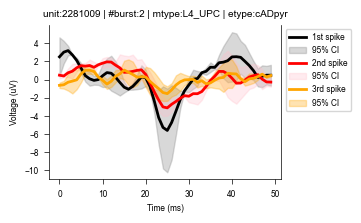

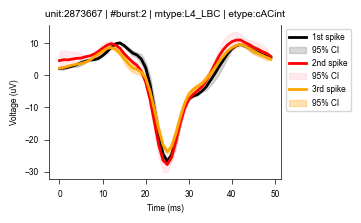

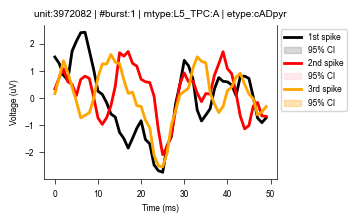

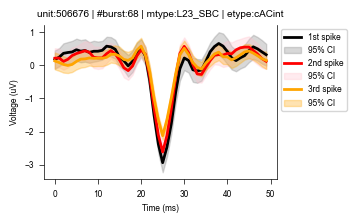

In [21]:
%%time

# compute mean and ci95 of first two spikes in bursts
NUM_SPIKES = 3

# setup window duration
WINDOW_MS = 2.5 
window_frames = int(WINDOW_MS / (1 / sfreq) / 1000)

# choose first unit
for unit_ix in range(len(bursting_units)):

    # setup unit
    b_unit = bursting_units[unit_ix]
    
    # get first two waveforms in all bursts for this unit
    waves_by_burst = get_burst_first_n_waveforms(Recording, Gtruth, bursts, b_unit, sfreq, peak_pos=int(window_frames/2), window=window_frames, frames_before=100, frames_after=100, num_spikes=NUM_SPIKES)

    # mean and ci95 of first and second burst spikes over bursts
    mean_waves = waves_by_burst.mean(axis=0)
    ci95_waves = ci95(waves_by_burst)

    # setup plot
    fig, ax = plt.subplots(figsize=(3,2))

    # first burst spike
    plot_mean_with_ci_line(ax, np.arange(0,window_frames,1), mean_waves[0,:], mean_waves[0,:]-ci95_waves[0,:], mean_waves[0,:]+ci95_waves[0,:], 
                            title="", linecolor='k', areacolor='grey', linelabel='1st spike', arealabel='95% CI',
                            xlabel="", ylabel="Y");

    # second burst spike
    plot_mean_with_ci_line(ax, np.arange(0,window_frames,1), mean_waves[1,:], mean_waves[1,:]-ci95_waves[1,:], mean_waves[1,:]+ci95_waves[1,:], 
                            title="", linecolor='r', areacolor='pink', linelabel='2nd spike', arealabel='95% CI',
                            xlabel="Time (ms)", ylabel="Voltage (uV)");

    # third burst spike
    plot_mean_with_ci_line(ax, np.arange(0,window_frames,1), mean_waves[2,:], mean_waves[2,:]-ci95_waves[2,:], mean_waves[2,:]+ci95_waves[2,:], 
                            title="", linecolor='orange', areacolor='orange', linelabel='3rd spike', arealabel='95% CI',
                            xlabel="Time (ms)", ylabel="Voltage (uV)");
    ax.legend(bbox_to_anchor=(1,1));
    ax.set_title(f"""unit:{b_unit} | #burst:{len(bursts[b_unit])} | mtype:{Gtruth.get_property("mtype", [b_unit])[0]} | etype:{Gtruth.get_property("etype", [b_unit])[0]}""");

    # save
    plt.savefig(f"figures/6_supp/fig3/fig3C_burst_amplitude_modulation_examples_unit_{b_unit}.svg", **savefig_cfg)

### Burst >=2 spike & thr 21 ms

In [ ]:
# %%time 

# # find bursting units -----------------------------------------------------------------------

# # setup burst parameters
# min_spikes = 2            # minimum spike in burst (min=2 max 4 as in Allen BD)
# isi_thresh_sec = 0.021   # (default=20 ms as in Allen BD, 2020, JN)

# # find bursts
# bursts = dict()
# n_bursts = []
# for unit in unit_ids:
#     spike_ttp_secs = Gtruth.get_unit_spike_train(unit) / sfreq # timestamps in seconds
#     burst = find_bursts_isi(spike_ttp_secs, isi_threshold=isi_thresh_sec, min_spikes=min_spikes)
#     n_bursts.append(len(burst))
#     bursts[unit] = burst

# # unit-test
# # test_find_bursts_isi()

# # plot number of bursts by cell
# plt.figure(figsize=(5,2))
# plt.plot(n_bursts, linewidth=1)
# plt.ylabel('number of bursts')
# plt.xlabel('units')

# # find bursting unit ids
# bursting_units = unit_ids[np.where(np.array(n_bursts) > 0)[0]]
# non_bursting_units = unit_ids[np.where(np.array(n_bursts) == 0)[0]]
# print('number of bursting units:', len(bursting_units))
# print('number of non-bursting units:', len(non_bursting_units))
# print('bursting units:', bursting_units)


# # compute mean and ci95 of first two spikes in bursts ----------------------------------------------------------------

# NUM_SPIKES = 2
# WINDOW_MS = 2.5 # setup window duration 
# window_frames = int(WINDOW_MS / (1 / sfreq) / 1000)

# mean_waves_all = []

# # choose first unit
# for unit_ix in range(len(bursting_units)):

#     # setup unit
#     b_unit = bursting_units[unit_ix]

#     # keep unit with more than 1 burst for statistics
#     if len(bursts[b_unit]) > 1:

#         # get first two waveforms in all bursts for this unit
#         waves_by_burst = get_burst_first_n_waveforms(Recording, Gtruth, bursts, b_unit, sfreq, peak_pos=int(window_frames/2), window=window_frames, frames_before=100, frames_after=100, num_spikes=NUM_SPIKES)
        
#         # mean and ci95 of first and second burst spikes over bursts
#         mean_waves = waves_by_burst.mean(axis=0)
#         ci95_waves = ci95(waves_by_burst)

#         # store
#         mean_waves_all.append(mean_waves)

#         # setup plot
#         fig, ax = plt.subplots(figsize=(3,2))

#         # first burst spike
#         plot_mean_with_ci_line(ax, np.arange(0,window_frames,1), mean_waves[0,:], mean_waves[0,:]-ci95_waves[0,:], mean_waves[0,:]+ci95_waves[0,:], 
#                                 title="", linecolor='k', areacolor='grey', linelabel='1st spike', arealabel='95% CI',
#                                 xlabel="", ylabel="Y");

#         # second burst spike
#         plot_mean_with_ci_line(ax, np.arange(0,window_frames,1), mean_waves[1,:], mean_waves[1,:]-ci95_waves[1,:], mean_waves[1,:]+ci95_waves[1,:], 
#                                 title="", linecolor='r', areacolor='pink', linelabel='2nd spike', arealabel='95% CI',
#                                 xlabel="Time (ms)", ylabel="Voltage (uV)");
#         ax.legend(bbox_to_anchor=(1,1));
#         ax.set_title(f"""unit:{b_unit} | #burst:{len(bursts[b_unit])} | mtype:{Gtruth.get_property("mtype", [b_unit])[0]} | etype:{Gtruth.get_property("etype", [b_unit])[0]}""");



# # Plot Statistics  ------------------------------------------------------------------------

# # shape dataset
# neg_amps = np.array(mean_waves_all).min(axis=(2))
# neg_amp_1st_spikes = neg_amps[:,0] # by unit
# neg_amp_2nd_spikes = neg_amps[:,1] # by unit

# df = pd.DataFrame()
# df['Amplitudes'] = pd.DataFrame(np.hstack([neg_amp_1st_spikes, neg_amp_2nd_spikes]))
# df['Spike rank'] = ['1st spike'] * len(neg_amp_1st_spikes) + ['2nd spike'] * len(neg_amp_2nd_spikes)

# # Put arrays into a dataframe for seaborn
# # Make the boxplot
# # setup plot
# fig, ax = plt.subplots(figsize=(2,2))

# # plot
# ax = sns.boxplot(
#     ax=ax,
#     data=df,
#     x="Spike rank",
#     y="Amplitudes",
#     notch=True,
#     palette=["k", "r"],
#     width=0.4,
#     linewidth=0.5,
#     flierprops={
#         "marker": ".",
#         "markersize": 3,
#     },
# );

# # minor ticks
# locmin = matplotlib.ticker.LogLocator(
#     base=10.0,
#     subs=np.arange(0, 1.1, 0.1),
#     numticks=10,
# );

# # axes
# ax.spines[["top", "right"]].set_visible(False);
# ax.legend("", frameon=False);

# # disconnect axes (R style)
# ax.spines["bottom"].set_position(("axes", -0.05));
# ax.yaxis.set_ticks_position("left");
# ax.spines["left"].set_position(("axes", -0.05));

# # ax.legend("", frameon=False)
# ax.set_ylabel("Trough amplitudes (\u03bcV)");
# ax.set_xlabel("Spike order within burst");
# ax.hlines(xmin=-0.2, xmax=1.2, y=0, color='k', linewidth=1, linestyle='--');

# # statistical test (Wicoxon signed-rank test, a non-parametric paired t-test)
# z, p = wilcoxon(neg_amp_1st_spikes, y=neg_amp_2nd_spikes, zero_method='wilcox', correction=False, alternative='less')
# print("""Wilcoxon test: 1 vs. 2, z={z}, p={p}, N_1={len(neg_amp_1st_spikes)}""")

#### Plot 

- average 1st and 2nd burst spikes

### Remove outlier

In [ ]:
# # shape dataset
# neg_amps = np.array(mean_waves_all).min(axis=(2))

# # remove outlier
# neg_amps = neg_amps[neg_amps[:,0] > -25,:]

# neg_amp_1st_spikes = neg_amps[:,0] # by unit
# neg_amp_2nd_spikes = neg_amps[:,1] # by unit

# df = pd.DataFrame()
# df['Amplitudes'] = pd.DataFrame(np.hstack([neg_amp_1st_spikes, neg_amp_2nd_spikes]))
# df['Spike rank'] = ['1st spike'] * len(neg_amp_1st_spikes) + ['2nd spike'] * len(neg_amp_2nd_spikes)

In [ ]:
# # Put arrays into a dataframe for seaborn
# # Make the boxplot
# # setup plot
# fig, ax = plt.subplots(figsize=(2,2))

# # plot
# ax = sns.boxplot(
#     ax=ax,
#     data=df,
#     x="Spike rank",
#     y="Amplitudes",
#     notch=True,
#     palette=["k", "r"],
#     width=0.4,
#     linewidth=0.5,
#     flierprops={
#         "marker": ".",
#         "markersize": 3,
#     },
# );

# # minor ticks
# locmin = matplotlib.ticker.LogLocator(
#     base=10.0,
#     subs=np.arange(0, 1.1, 0.1),
#     numticks=10,
# );

# # axes
# ax.spines[["top", "right"]].set_visible(False);
# ax.legend("", frameon=False);

# # disconnect axes (R style)
# ax.spines["bottom"].set_position(("axes", -0.05));
# ax.yaxis.set_ticks_position("left");
# ax.spines["left"].set_position(("axes", -0.05));

# # ax.legend("", frameon=False)
# ax.set_ylabel("Trough amplitudes (\u03bcV)");
# ax.set_xlabel("Spike order within burst");
# ax.hlines(xmin=-0.2, xmax=1.2, y=0, color='k', linewidth=1, linestyle='--');

# # statistical test (Wicoxon signed-rank test, a non-parametric paired t-test)
# z, p = wilcoxon(neg_amp_1st_spikes, y=neg_amp_2nd_spikes, zero_method='wilcox', correction=False, alternative='less')
# print(f"""1 vs. 2, z={z}, p={p}, N_1={len(neg_amp_1st_spikes)}""")

## Non-bursting units

In [ ]:
# %%time 

# # find bursting units
# # setup burst parameters
# min_spikes = 2            # minimum spike in burst (min=2 max 4 as in Allen BD)
# min_isi = 0.021 
# max_isi = 0.041

# # find bursts
# sequences_in_isi_range = dict()
# n_sequences = []

# # loop over non-bursting units
# for unit in non_bursting_units:

#     spike_ttp_secs = Gtruth.get_unit_spike_train(unit) / sfreq # timestamps in seconds
#     sequence_in_isi_range = find_in_isi_range(spike_ttp_secs, min_isi=min_isi, max_isi=max_isi, min_spikes=min_spikes)
#     n_sequences.append(len(sequence_in_isi_range))
#     sequences_in_isi_range[unit] = sequence_in_isi_range

# # plot number of bursts by cell
# plt.figure(figsize=(5,2))
# plt.plot(n_sequences, linewidth=1)
# plt.ylabel('number of sequences in isi range')
# plt.xlabel('units')

# # find bursting unit ids
# # bursting_units = unit_ids[np.where(np.array(n_sequences) > 0)[0]]
# print('number of non-bursting units:', len(non_bursting_units))

In [ ]:
# # compute mean and ci95 of first two spikes in bursts

# NUM_SPIKES = 2
# WINDOW_MS = 2.5 # setup window duration 
# window_frames = int(WINDOW_MS / (1 / sfreq) / 1000)

# mean_waves_all = []

# # choose first unit
# for unit_ix in range(len(non_bursting_units)):

#     # setup unit
#     b_unit = non_bursting_units[unit_ix]

#     # keep unit with more than 1 burst for statistics
#     if len(sequences_in_isi_range[b_unit]) > 1:

#         # get first two waveforms in all bursts for this unit
#         waves_by_burst = get_burst_first_n_waveforms(Recording, Gtruth, sequences_in_isi_range, b_unit, sfreq, peak_pos=int(window_frames/2), window=window_frames, frames_before=100, frames_after=100, num_spikes=NUM_SPIKES)
        
#         # mean and ci95 of first and second burst spikes over bursts
#         mean_waves = waves_by_burst.mean(axis=0)
#         ci95_waves = ci95(waves_by_burst)

#         # store
#         mean_waves_all.append(mean_waves)

#         # setup plot
#         fig, ax = plt.subplots(figsize=(3,2))

#         # first burst spike
#         plot_mean_with_ci_line(ax, np.arange(0,window_frames,1), mean_waves[0,:], mean_waves[0,:]-ci95_waves[0,:], mean_waves[0,:]+ci95_waves[0,:], 
#                                 title="", linecolor='k', areacolor='grey', linelabel='1st spike', arealabel='95% CI',
#                                 xlabel="", ylabel="Y");

#         # second burst spike
#         plot_mean_with_ci_line(ax, np.arange(0,window_frames,1), mean_waves[1,:], mean_waves[1,:]-ci95_waves[1,:], mean_waves[1,:]+ci95_waves[1,:], 
#                                 title="", linecolor='r', areacolor='pink', linelabel='2nd spike', arealabel='95% CI',
#                                 xlabel="Time (ms)", ylabel="Voltage (uV)");
#         ax.legend(bbox_to_anchor=(1,1));
#         ax.set_title(f"""unit:{b_unit} | #burst:{len(bursts[b_unit])} | mtype:{Gtruth.get_property("mtype", [b_unit])[0]} | etype:{Gtruth.get_property("etype", [b_unit])[0]}""");

In [ ]:
# # shape dataset --------------------------------------------------
# df = pd.DataFrame()
# neg_amps = np.array(mean_waves_all).min(axis=(2))
# neg_amp_1st_spikes = neg_amps[:,0] # by unit
# neg_amp_2nd_spikes = neg_amps[:,1] # by unit
# df['Amplitudes'] = pd.DataFrame(np.hstack([neg_amp_1st_spikes, neg_amp_2nd_spikes]))
# df['Spike rank'] = ['1st spike'] * len(neg_amp_1st_spikes) + ['2nd spike'] * len(neg_amp_2nd_spikes)

# # plot --------------------------------------------------
# # Put arrays into a dataframe for seaborn
# # Make the boxplot
# # setup plot
# fig, ax = plt.subplots(figsize=(2,2))

# # plot
# ax = sns.boxplot(
#     ax=ax,
#     data=df,
#     x="Spike rank",
#     y="Amplitudes",
#     notch=True,
#     palette=["k", "r"],
#     width=0.4,
#     linewidth=0.5,
#     flierprops={
#         "marker": ".",
#         "markersize": 3,
#     },
# );

# # minor ticks
# locmin = matplotlib.ticker.LogLocator(
#     base=10.0,
#     subs=np.arange(0, 1.1, 0.1),
#     numticks=10,
# );

# # axes
# ax.spines[["top", "right"]].set_visible(False);
# ax.legend("", frameon=False);

# # disconnect axes (R style)
# ax.spines["bottom"].set_position(("axes", -0.05));
# ax.yaxis.set_ticks_position("left");
# ax.spines["left"].set_position(("axes", -0.05));

# # ax.legend("", frameon=False)
# ax.set_ylabel("Trough amplitudes (\u03bcV)");
# ax.set_xlabel("Spike order within burst");
# ax.hlines(xmin=-0.2, xmax=1.2, y=0, color='k', linewidth=1, linestyle='--');

# # statistical test (Wicoxon signed-rank test, a non-parametric paired t-test)
# z, p = wilcoxon(neg_amp_1st_spikes, y=neg_amp_2nd_spikes, zero_method='wilcox', correction=False, alternative='less')
# print(f"""1 vs. 2, z={z}, p={p}, N_1={len(neg_amp_1st_spikes)}""")

In [ ]:
# %%time 

# # find sequences of spikes within ISI range -------------------------------------------------

# # setup burst parameters
# min_spikes = 2            # minimum spike in burst (min=2 max 4 as in Allen BD)
# min_isi=0.041
# max_isi=0.061

# # find bursts
# sequences_in_isi_range = dict()
# n_sequences = []

# # loop over non-bursting units
# for unit in non_bursting_units:

#     spike_ttp_secs = Gtruth.get_unit_spike_train(unit) / sfreq # timestamps in seconds
#     sequence_in_isi_range = find_in_isi_range(spike_ttp_secs, min_isi=min_isi, max_isi=max_isi, min_spikes=min_spikes)
#     n_sequences.append(len(sequence_in_isi_range))
#     sequences_in_isi_range[unit] = sequence_in_isi_range

# # plot number of bursts by cell
# plt.figure(figsize=(5,2))
# plt.plot(n_sequences, linewidth=1)
# plt.ylabel('number of sequences in isi range')
# plt.xlabel('units')

# # find bursting unit ids
# # bursting_units = unit_ids[np.where(np.array(n_sequences) > 0)[0]]
# print('number of non-bursting units:', len(non_bursting_units))



# # Plot mean and ci95 of first two spikes with ISI within range ---------------------------------------


# NUM_SPIKES = 2
# WINDOW_MS = 2.5 # setup window duration 
# window_frames = int(WINDOW_MS / (1 / sfreq) / 1000)

# mean_waves_all = []

# # choose first unit
# for unit_ix in range(len(non_bursting_units)):

#     # setup unit
#     b_unit = non_bursting_units[unit_ix]

#     # keep unit with more than 1 burst for statistics
#     if len(sequences_in_isi_range[b_unit]) > 1:

#         # get first two waveforms in all bursts for this unit
#         waves_by_burst = get_burst_first_n_waveforms(Recording, Gtruth, sequences_in_isi_range, b_unit, sfreq, peak_pos=int(window_frames/2), window=window_frames, frames_before=100, frames_after=100, num_spikes=NUM_SPIKES)
        
#         # mean and ci95 of first and second burst spikes over bursts
#         mean_waves = waves_by_burst.mean(axis=0)
#         ci95_waves = ci95(waves_by_burst)

#         # store
#         mean_waves_all.append(mean_waves)

#         # setup plot
#         fig, ax = plt.subplots(figsize=(3,2))

#         # first burst spike
#         plot_mean_with_ci_line(ax, np.arange(0,window_frames,1), mean_waves[0,:], mean_waves[0,:]-ci95_waves[0,:], mean_waves[0,:]+ci95_waves[0,:], 
#                                 title="", linecolor='k', areacolor='grey', linelabel='1st spike', arealabel='95% CI',
#                                 xlabel="", ylabel="Y");

#         # second burst spike
#         plot_mean_with_ci_line(ax, np.arange(0,window_frames,1), mean_waves[1,:], mean_waves[1,:]-ci95_waves[1,:], mean_waves[1,:]+ci95_waves[1,:], 
#                                 title="", linecolor='r', areacolor='pink', linelabel='2nd spike', arealabel='95% CI',
#                                 xlabel="Time (ms)", ylabel="Voltage (uV)");
#         ax.legend(bbox_to_anchor=(1,1));
#         ax.set_title(f"""unit:{b_unit} | #burst:{len(bursts[b_unit])} | mtype:{Gtruth.get_property("mtype", [b_unit])[0]} | etype:{Gtruth.get_property("etype", [b_unit])[0]}""");


#         # shape dataset --------------------------------------------------
# df = pd.DataFrame()
# neg_amps = np.array(mean_waves_all).min(axis=(2))
# neg_amp_1st_spikes = neg_amps[:,0] # by unit
# neg_amp_2nd_spikes = neg_amps[:,1] # by unit
# df['Amplitudes'] = pd.DataFrame(np.hstack([neg_amp_1st_spikes, neg_amp_2nd_spikes]))
# df['Spike rank'] = ['1st spike'] * len(neg_amp_1st_spikes) + ['2nd spike'] * len(neg_amp_2nd_spikes)



# # plot statistics --------------------------------------------------


# # Put arrays into a dataframe for seaborn
# # Make the boxplot
# # setup plot
# fig, ax = plt.subplots(figsize=(2,2))

# # plot
# ax = sns.boxplot(
#     ax=ax,
#     data=df,
#     x="Spike rank",
#     y="Amplitudes",
#     notch=True,
#     palette=["k", "r"],
#     width=0.4,
#     linewidth=0.5,
#     flierprops={
#         "marker": ".",
#         "markersize": 3,
#     },
# );

# # minor ticks
# locmin = matplotlib.ticker.LogLocator(
#     base=10.0,
#     subs=np.arange(0, 1.1, 0.1),
#     numticks=10,
# );

# # axes
# ax.spines[["top", "right"]].set_visible(False);
# ax.legend("", frameon=False);

# # disconnect axes (R style)
# ax.spines["bottom"].set_position(("axes", -0.05));
# ax.yaxis.set_ticks_position("left");
# ax.spines["left"].set_position(("axes", -0.05));

# # ax.legend("", frameon=False)
# ax.set_ylabel("Trough amplitudes (\u03bcV)");
# ax.set_xlabel("Spike order within burst");
# ax.hlines(xmin=-0.2, xmax=1.2, y=0, color='k', linewidth=1, linestyle='--');

# # statistical test (Wicoxon signed-rank test, a non-parametric paired t-test)
# z, p = wilcoxon(neg_amp_1st_spikes, y=neg_amp_2nd_spikes, zero_method='wilcox', correction=False, alternative='less')
# print(f"""Wilcoxon test: 1 vs. 2, z={z}, p={p}, N_1={len(neg_amp_1st_spikes)}""")

In [ ]:
# %%time 

# # find sequences of spikes within ISI range -------------------------------------------------

# # setup burst parameters
# min_spikes = 2            # minimum spike in burst (min=2 max 4 as in Allen BD)
# min_isi=0.041
# max_isi=0.061

# # find bursts
# sequences_in_isi_range = dict()
# n_sequences = []

# # loop over non-bursting units
# for unit in non_bursting_units:

#     spike_ttp_secs = Gtruth.get_unit_spike_train(unit) / sfreq # timestamps in seconds
#     sequence_in_isi_range = find_in_isi_range(spike_ttp_secs, min_isi=min_isi, max_isi=max_isi, min_spikes=min_spikes)
#     n_sequences.append(len(sequence_in_isi_range))
#     sequences_in_isi_range[unit] = sequence_in_isi_range

# # plot number of bursts by cell
# plt.figure(figsize=(5,2))
# plt.plot(n_sequences, linewidth=1)
# plt.ylabel('number of sequences in isi range')
# plt.xlabel('units')

# # find bursting unit ids
# # bursting_units = unit_ids[np.where(np.array(n_sequences) > 0)[0]]
# print('number of non-bursting units:', len(non_bursting_units))



# # Plot mean and ci95 of first two spikes with ISI within range ---------------------------------------


# NUM_SPIKES = 2
# WINDOW_MS = 2.5 # setup window duration 
# window_frames = int(WINDOW_MS / (1 / sfreq) / 1000)

# mean_waves_all = []

# # choose first unit
# for unit_ix in range(len(non_bursting_units)):

#     # setup unit
#     b_unit = non_bursting_units[unit_ix]

#     # keep unit with more than 1 burst for statistics
#     if len(sequences_in_isi_range[b_unit]) > 1:

#         # get first two waveforms in all bursts for this unit
#         waves_by_burst = get_burst_first_n_waveforms(Recording, Gtruth, sequences_in_isi_range, b_unit, sfreq, peak_pos=int(window_frames/2), window=window_frames, frames_before=100, frames_after=100, num_spikes=NUM_SPIKES)
        
#         # mean and ci95 of first and second burst spikes over bursts
#         mean_waves = waves_by_burst.mean(axis=0)
#         ci95_waves = ci95(waves_by_burst)

#         # store
#         mean_waves_all.append(mean_waves)

#         # setup plot
#         fig, ax = plt.subplots(figsize=(3,2))

#         # first burst spike
#         plot_mean_with_ci_line(ax, np.arange(0,window_frames,1), mean_waves[0,:], mean_waves[0,:]-ci95_waves[0,:], mean_waves[0,:]+ci95_waves[0,:], 
#                                 title="", linecolor='k', areacolor='grey', linelabel='1st spike', arealabel='95% CI',
#                                 xlabel="", ylabel="Y");

#         # second burst spike
#         plot_mean_with_ci_line(ax, np.arange(0,window_frames,1), mean_waves[1,:], mean_waves[1,:]-ci95_waves[1,:], mean_waves[1,:]+ci95_waves[1,:], 
#                                 title="", linecolor='r', areacolor='pink', linelabel='2nd spike', arealabel='95% CI',
#                                 xlabel="Time (ms)", ylabel="Voltage (uV)");
#         ax.legend(bbox_to_anchor=(1,1));
#         ax.set_title(f"""unit:{b_unit} | #burst:{len(bursts[b_unit])} | mtype:{Gtruth.get_property("mtype", [b_unit])[0]} | etype:{Gtruth.get_property("etype", [b_unit])[0]}""");


#         # shape dataset --------------------------------------------------
# df = pd.DataFrame()
# neg_amps = np.array(mean_waves_all).min(axis=(2))
# neg_amp_1st_spikes = neg_amps[:,0] # by unit
# neg_amp_2nd_spikes = neg_amps[:,1] # by unit
# df['Amplitudes'] = pd.DataFrame(np.hstack([neg_amp_1st_spikes, neg_amp_2nd_spikes]))
# df['Spike rank'] = ['1st spike'] * len(neg_amp_1st_spikes) + ['2nd spike'] * len(neg_amp_2nd_spikes)



# # plot statistics --------------------------------------------------


# # Put arrays into a dataframe for seaborn
# # Make the boxplot
# # setup plot
# fig, ax = plt.subplots(figsize=(2,2))

# # plot
# ax = sns.boxplot(
#     ax=ax,
#     data=df,
#     x="Spike rank",
#     y="Amplitudes",
#     notch=True,
#     palette=["k", "r"],
#     width=0.4,
#     linewidth=0.5,
#     flierprops={
#         "marker": ".",
#         "markersize": 3,
#     },
# );

# # minor ticks
# locmin = matplotlib.ticker.LogLocator(
#     base=10.0,
#     subs=np.arange(0, 1.1, 0.1),
#     numticks=10,
# );

# # axes
# ax.spines[["top", "right"]].set_visible(False);
# ax.legend("", frameon=False);

# # disconnect axes (R style)
# ax.spines["bottom"].set_position(("axes", -0.05));
# ax.yaxis.set_ticks_position("left");
# ax.spines["left"].set_position(("axes", -0.05));

# # ax.legend("", frameon=False)
# ax.set_ylabel("Trough amplitudes (\u03bcV)");
# ax.set_xlabel("Spike order within burst");
# ax.hlines(xmin=-0.2, xmax=1.2, y=0, color='k', linewidth=1, linestyle='--');

# # statistical test (Wicoxon signed-rank test, a non-parametric paired t-test)
# z, p = wilcoxon(neg_amp_1st_spikes, y=neg_amp_2nd_spikes, zero_method='wilcox', correction=False, alternative='less')
# print(f"""Wilcoxon test: 1 vs. 2, z={z}, p={p}, N_1={len(neg_amp_1st_spikes)}""")

## Paper figures

number of bursting units: 126
number of non-bursting units: 1710
bursting units: ['1005388' '1021816' '1032450' '1072986' '1081680' '1092498' '1095775'
 '1095930' '1100452' '1101417' '1106785' '1106850' '1204031' '1209409'
 '1231905' '1280189' '1336001' '1353447' '1370134' '1406153' '1422795'
 '1428221' '1429112' '1479668' '1484659' '1520831' '1552383' '1557693'
 '1557775' '1572725' '1573256' '1583638' '1594602' '1601466' '1610105'
 '1666897' '1677051' '1679334' '1700189' '1709486' '1709793' '1721410'
 '1724717' '1736462' '1757135' '1783383' '1799236' '1808210' '1851145'
 '1858700' '1862764' '1868922' '1873763' '1880940' '1898525' '1899599'
 '1956231' '1968293' '1979019' '1991859' '2014557' '2015083' '2026293'
 '2029728' '2034092' '2063293' '2065572' '2072808' '2075781' '2083630'
 '2096886' '2099414' '2104770' '2106081' '2108785' '2110017' '2115968'
 '2152223' '2159081' '2160766' '2173940' '2281009' '2639635' '2797125'
 '2873667' '2874926' '3479378' '3486840' '3566760' '3569545' '35714

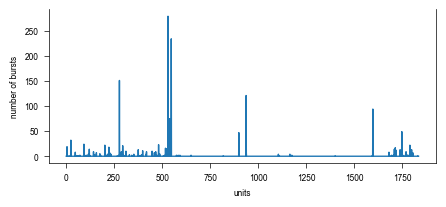

In [6]:
%%time 

# find bursting units
# setup burst parameters
min_spikes = 2            # minimum spike in burst (min=2 max 4 as in Allen BD)
isi_thresh_sec = 0.021    # (default=20 ms as in Allen BD, 2020, JN)

# find bursts
bursts = dict()
n_bursts = []
for unit in unit_ids:
    spike_ttp_secs = Gtruth.get_unit_spike_train(unit) / sfreq # timestamps in seconds
    burst = find_bursts_isi(spike_ttp_secs, isi_threshold=isi_thresh_sec, min_spikes=min_spikes)
    n_bursts.append(len(burst))
    bursts[unit] = burst

# unit-test
# test_find_bursts_isi()

# plot number of bursts by cell
plt.figure(figsize=(5,2))
plt.plot(n_bursts, linewidth=1)
plt.ylabel('number of bursts')
plt.xlabel('units')

# find bursting unit ids
bursting_units = unit_ids[np.where(np.array(n_bursts) > 0)[0]]
non_bursting_units = unit_ids[np.where(np.array(n_bursts) == 0)[0]]
print('number of bursting units:', len(bursting_units))
print('number of non-bursting units:', len(non_bursting_units))
print('bursting units:', bursting_units)

### Amplitude modulation (non-bursting units)

- execution time: 30 min

Wilcoxon test: 1 vs. 2, z=727.0, p=0.35931978438002793, N_1=55
Wilcoxon test: 1 vs. 2, z=2849.0, p=0.9554501089620976, N_1=97
Wilcoxon test: 1 vs. 2, z=8528.0, p=0.9999998908067473, N_1=151
Wilcoxon test: 1 vs. 2, z=29202.0, p=1.0, N_1=267
CPU times: user 5h 15min 39s, sys: 10h 24min 4s, total: 15h 39min 43s
Wall time: 29min 54s


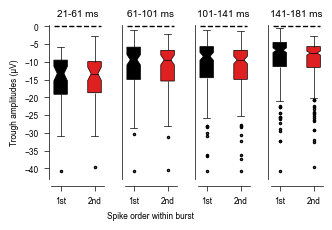

In [16]:
%%time 

# Amplitude modulation by ISI for non-bursting units

# setup ISI ranges to loop over
min_isis = [0.021, 0.061, 0.101, 0.141]
max_isis = [0.061, 0.101, 0.141, 0.181]
labels = ['21-61 ms', '61-101 ms', '101-141 ms', '141-181 ms']

# setup parameters of spike sequences with ISI within range
MIN_SPIKES = 2             # min # of spikes in sequence
NUM_SPIKES = 2             # max # of spikes to keep
MIN_TROUGH_AMPLITUDE = -7.5 # (default=-7 uV): minimum trough amplitude which is ~3 X the background noise (~2.5, our paper fig. 2n) 
MIN_DURATION = 0.02        # (default=0.02 sec): minimum duration of spike sequence
WINDOW_MS = 2.5            # setup waveform duration in milliseconds
window_frames = int(WINDOW_MS / (1 / sfreq) / 1000)     # window in number of frames

# setup plot
fig, ax = plt.subplots(1, len(min_isis), figsize=(3.5, 2))

# plot modulation of trough amplitude by ISI duration
min_amplitude = []
for i_ix in range(len(min_isis)):
    z, p, df = plot_amplitude_modulation_by_isi(ax[i_ix], Recording, Gtruth, non_bursting_units, sfreq, min_isis[i_ix], max_isis[i_ix], MIN_SPIKES, window_frames, NUM_SPIKES, min_duration=MIN_DURATION, min_amplitude=MIN_TROUGH_AMPLITUDE)
    ax[i_ix].set_title(labels[i_ix])     # title with isi range
    y_min = np.min(min_amplitude.append(df.Amplitudes.min())) # get common y_min

# set common y-range
for i_ix in range(len(min_isis)): 
    ax[i_ix].set_ylim([y_min, 0.5])        # same yticks
    if i_ix > 0: ax[i_ix].set_yticks([]) # ticks only for 1st panel
    
# legend
ax[0].set_ylabel("Trough amplitudes (\u03bcV)");
ax[1].set_xlabel("Spike order within burst");
plt.subplots_adjust(wspace=0.4, hspace=0.4) # aesthetics

# save
plt.savefig("figures/6_supp/fig3/fig3C_non_burst_amplitude_modulation_snr_3xMAD.svg", **savefig_cfg)

### Amplitude modulation (bursting units)

- execution time: 10 min

Wilcoxon test: 1 vs. 2, z=23.0, p=0.0006046295166015625, N_1=20
Wilcoxon test: 1 vs. 2, z=8.0, p=4.76837158203125e-05, N_1=19
Wilcoxon test: 1 vs. 2, z=1.0, p=0.00390625, N_1=9
Wilcoxon test: 1 vs. 2, z=37.0, p=0.962890625, N_1=9
Wilcoxon test: 1 vs. 2, z=62.0, p=0.8780517578125, N_1=13
CPU times: user 1h 55min 38s, sys: 3h 47min 39s, total: 5h 43min 18s
Wall time: 10min 55s


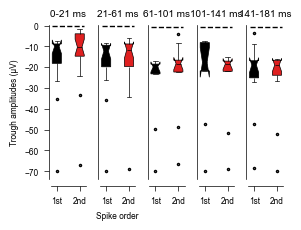

In [15]:
%%time 

# Amplitude modulation by ISI for bursting units

# setup ISI ranges to loop over (in seconds)
min_isis = [0,     0.021, 0.061, 0.101, 0.141]
max_isis = [0.021, 0.061, 0.101, 0.141, 0.181]
labels = ['0-21 ms', '21-61 ms', '61-101 ms', '101-141 ms', '141-181 ms']

# setup parameters of spike sequences with ISI within range
# note: burst spike between 2 and 4 in Allen BD
MIN_SPIKES = 2             # min # of spikes in sequence
NUM_SPIKES = 2             # max # of spikes to keep
MIN_TROUGH_AMPLITUDE = -7.5  # (default=-7 uV): minimum trough amplitude which is ~ 3X the background noise (~2.5, our paper fig. 2n) 
MIN_DURATION = 0.02        # (default=0.02 sec): minimum duration of spike sequence
WINDOW_MS = 2.5            # setup waveform duration in milliseconds
window_frames = int(WINDOW_MS / (1 / sfreq) / 1000) # window in number of frames

# setup plot
fig, ax = plt.subplots(1, len(min_isis), figsize=(3,2))

# plot amplitude modulation by ISI
for i_ix in range(len(min_isis)):
    z, p, df = plot_amplitude_modulation_by_isi(ax[i_ix], Recording, Gtruth, bursting_units, sfreq, min_isis[i_ix], max_isis[i_ix], MIN_SPIKES, window_frames, NUM_SPIKES, min_duration=MIN_DURATION, min_amplitude=MIN_TROUGH_AMPLITUDE)
    ax[i_ix].set_title(labels[i_ix])     # title with isi range
    y_min = np.min(min_amplitude.append(df.Amplitudes.min())) # get common y_min

# set common y-range
for i_ix in range(len(min_isis)): 
    ax[i_ix].set_ylim([y_min, 0.5])      # same yticks
    if i_ix > 0: ax[i_ix].set_yticks([]) # ticks only for 1st panel

# legend
ax[0].set_ylabel("Trough amplitudes (\u03bcV)");
ax[1].set_xlabel("Spike order");
plt.subplots_adjust(wspace=0.4, hspace=0.4) # aesthetics

# save
plt.savefig("figures/6_supp/fig3/fig3D_burst_amplitude_modulation_snr_3xMAD.svg", **savefig_cfg)

### Width modulation (bursting units)

as defined in Allen BD: width of spike at half maximal amplitude

- execution time: 10 min

Wilcoxon test: 1 vs. 2, z=57.5, p=0.19792424118178936, N_1=20
Wilcoxon test: 1 vs. 2, z=5.0, p=0.9386437026359151, N_1=19
Wilcoxon test: 1 vs. 2, z=4.5, p=0.2071080891212626, N_1=9
Wilcoxon test: 1 vs. 2, z=6.0, p=0.3527284930556367, N_1=9
Wilcoxon test: 1 vs. 2, z=20.5, p=0.12981988569064323, N_1=13
CPU times: user 1h 54min 58s, sys: 3h 45min 55s, total: 5h 40min 53s
Wall time: 10min 50s


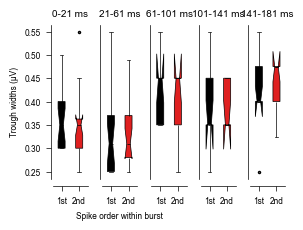

In [19]:
%%time 

# Spike width modulation by ISI for bursting units

# setup ISI ranges to loop over
min_isis = [0,     0.021, 0.061, 0.101, 0.141]
max_isis = [0.021, 0.061, 0.101, 0.141, 0.181]
labels = ['0-21 ms', '21-61 ms', '61-101 ms', '101-141 ms', '141-181 ms']
min_trough_amplitude = - 5 # (default=-5 uV): minimum trough amplitude which is about 2X the background noise (our paper fig. 2n) 

# setup parameters of spike sequences with ISI within range
# note: burst spike between 2 and 4 in Allen BD
MIN_SPIKES = 2            # min # of spikes in sequence
NUM_SPIKES = 2            # max # of spikes to keep
MIN_TROUGH_AMPLITUDE = -7.5 # minimum trough amplitude which is about 2X the background noise (our paper fig. 2n) 
MIN_DURATION = 0.02       # (default=0.02 sec): minimum duration of spike sequence
WINDOW_MS = 2.5           # setup window duration in milliseconds
window_frames = int(WINDOW_MS / (1 / sfreq) / 1000) # window in number of frames

# setup plot
fig, ax = plt.subplots(1, len(min_isis), figsize=(3,2))

# plot amplitude modulation by ISI
min_width = []
max_width = []

for i_ix in range(len(min_isis)):
    z, p, df = plot_width_modulation_by_isi(ax[i_ix], Recording, Gtruth, bursting_units, sfreq, min_isis[i_ix], max_isis[i_ix], MIN_SPIKES, window_frames, NUM_SPIKES, min_duration=MIN_DURATION, min_amplitude=MIN_TROUGH_AMPLITUDE)
    ax[i_ix].set_title(labels[i_ix])      # title with isi range

    # get common y-min and max
    y_min = np.min(min_width.append(df['Spike widths (ms)'].min())) # get common y_min
    y_max = np.max(max_width.append(df['Spike widths (ms)'].max())) # get common y_max

# set common y-range
for i_ix in range(len(min_isis)): 
    ax[i_ix].set_ylim([y_min, y_max])        # same yticks
    if i_ix > 0: ax[i_ix].set_yticks([])   # ticks only for 1st panel

# legend
ax[0].set_ylabel("Trough widths (\u03bcV)");
ax[1].set_xlabel("Spike order within burst");
plt.subplots_adjust(wspace=0.4, hspace=0.4) # aesthetics

# save
plt.savefig("figures/6_supp/fig3/fig3E_burst_width_modulation_snr_3xMAD.svg", **savefig_cfg)